In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


### import all required libraries

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Sequential
import keras, shutil
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D, Input, BatchNormalization, Activation, Add
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

##  Load the dataset

In [ ]:
path = "input/face-mask-detection/Dataset"
print(os.listdir(path))

# print number of samples in each class
print("with_mask samples: ", len(os.listdir(os.path.join(path, 'with_mask'))))
print("without_mask samples: ", len(os.listdir(os.path.join(path, "without_mask"))))

['without_mask', 'mask_weared_incorrect', 'with_mask']
with_mask samples:  2994
without_mask samples:  2994


In [ ]:
os.mkdir('temp')
os.mkdir('temp/with_mask')
os.mkdir('temp/without_mask')

for filename1, filename2 in zip(os.listdir(path + '/with_mask'), os.listdir(path + '/without_mask')):
    shutil.copy(os.path.join(path, 'with_mask/' + filename1), 'temp/with_mask')
    shutil.copy(os.path.join(path, 'without_mask/' + filename2), 'temp/without_mask')

In [ ]:
# create necessary directories for training and validation set
temp_path = 'temp/'
#os.mkdir(temp_path)

os.mkdir(os.path.join(temp_path, 'train'))
os.mkdir(os.path.join(temp_path, 'train/with_mask'))
os.mkdir(os.path.join(temp_path, 'train/without_mask'))

os.mkdir(os.path.join(temp_path, 'val'))
os.mkdir(os.path.join(temp_path, 'val/with_mask'))
os.mkdir(os.path.join(temp_path, 'val/without_mask'))

# print directories
print(os.listdir(temp_path))

['with_mask', 'without_mask', 'train', 'val']


In [ ]:
# Move the data from 'input/face-mask-detection/data' to 'train' and 'val' directories

path = 'temp/'

# move to 'train' directory
for filename in os.listdir(os.path.join(path, 'with_mask'))[0:2400]:
    src_path = os.path.join(path, 'with_mask/' + filename)
    dst_path = os.path.join(temp_path, 'train/with_mask/')
    shutil.move(src_path, dst_path)

for filename in os.listdir(os.path.join(path, 'without_mask'))[0:2400]:
    src_path = os.path.join(path , 'without_mask/' + filename)
    dst_path = os.path.join(temp_path, 'train/without_mask/')
    shutil.move(src_path, dst_path)
    
# move rest of the files to the 'val' directory
for filename in os.listdir(os.path.join(path, 'with_mask')):
    src_path = os.path.join(path, 'with_mask/' + filename)
    dst_path = os.path.join(temp_path, 'val/with_mask/')
    shutil.move(src_path, dst_path)
    
for filename in os.listdir(os.path.join(path, 'without_mask')):
    src_path = os.path.join(path, 'without_mask/' + filename)
    dst_path = os.path.join(temp_path, 'val/without_mask/')
    shutil.move(src_path, dst_path)

In [ ]:
# remove 'with_mask' and 'without_mask' directory from 'temp/'
os.rmdir(path + 'with_mask')
os.rmdir(path + 'without_mask')

print(os.listdir(path))

['train', 'val']


In [ ]:
# print number of samples in training and validation set
print("\n ---------------  Training samples  ------------------ \n")
print("with_mask samples: ", len(os.listdir(os.path.join(path, 'train/with_mask'))))
print("without_mask samples: ", len(os.listdir(os.path.join(path, 'train/without_mask'))))

print("\n ---------------  Validation samples  --------------------\n")
print("with_mask samples: ", len(os.listdir(os.path.join(path, 'val/with_mask'))))
print("without_mask samples: ", len(os.listdir(os.path.join(path, 'val/without_mask'))))


 ---------------  Training samples  ------------------ 

with_mask samples:  2400
without_mask samples:  2400

 ---------------  Validation samples  --------------------

with_mask samples:  594
without_mask samples:  594


In [ ]:
# to generate more images I will use Image Data Generator
datagen = ImageDataGenerator(rescale = 1.0/255, horizontal_flip = True, 
                            rotation_range = 20, 
                            width_shift_range =  0.2,
                            height_shift_range = 0.2)

train_batch_size = 32
train_dir = 'temp/train/'

# create train generator
train_gen = datagen.flow_from_directory(train_dir,
                                       target_size = (224, 224),
                                       batch_size = train_batch_size,
                                       class_mode = 'categorical')

val_batch_size = 32
val_dir = 'temp/val/'

# create val generator
val_gen = datagen.flow_from_directory(val_dir,
                                     target_size = (224, 224),
                                     batch_size = val_batch_size,
                                     class_mode = 'categorical')

Found 4800 images belonging to 2 classes.
Found 1188 images belonging to 2 classes.


In [ ]:
# print label encoding
print(train_gen.class_indices)


{'with_mask': 0, 'without_mask': 1}


In [ ]:
# get number of samples in training set and val set
train_num_samples = 0

for _, _, filenames in os.walk('temp/train/'):
    train_num_samples += len(filenames)
    
val_num_samples = 0

for _, _, filenames in os.walk('temp/val/'):
    val_num_samples += len(filenames)
    
print("train_num_samples: ",train_num_samples)
print("val_num_samples: ",val_num_samples)

train_num_samples:  4800
val_num_samples:  1188


## Visualize images generated by the Image Generator

In [ ]:
x, y = train_gen.next()

In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', 
               name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding='same',
              name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding='valid',
              name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2c')(X)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def convolution_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolution block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle Conv's window for the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character , used to name the layers, depending on their position in the network
    s -- integer, specifying the stride to be used
    """
    
    # defining the name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve filters
    F1, F2, F3 = filters
    
    # Save the input
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), padding='valid',
              name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding='same',
              name=conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding='valid',
              name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)
    
    # Shortcut path
    X_shortcut = Conv2D(filters = F3, kernel_size = (1,1), strides = (s,s), padding='valid',
                      name=conv_name_base+'1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)
    
    # Final step, Add shortcut value to main path and pass it through a Relu activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def ResNet50(input_shape=(64, 64, 3), classes=2):
    
    # define the input as a tensor with shape input_shape
    X_input = Input(shape=input_shape)
    
    # Stage 1
    X = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding='valid',
              name='conv1', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3,3), strides=(2,2))(X)
    
    # Stage 2
    X = convolution_block(X, f=3, filters=[64,64,256], stage=2, block='a', s=2)
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block='b')
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block='c')
    
    # Stage 3
    X = convolution_block(X, f=3, filters=[128,128,512], stage=3, block='a', s=2)
    X = identity_block(X, f=3, filters=[128,128,512],stage=3, block='b')
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block='c')
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block='d')
    
    # Stage 4
    X = convolution_block(X, f=3, filters=[256,256,1024], stage=4, block='a', s=2)
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='b')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='c')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='d')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='e')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='f')
    
    # Stage 5
    X = convolution_block(X, f=3, filters=[512,512,2048], stage=5, block='a', s=2)
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block='b')
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block='c')
    
    # AVGPool
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(units=classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)
    
    # create model
    model = keras.Model(inputs = X_input, outputs=X, name='ResNet50')
    
    return model

In [ ]:
model = ResNet50(input_shape = (224,224,3), classes=2)

# print model summary
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 222, 222, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 222, 222, 64  256         ['conv1[0][0]']                  
                                )                                                          

## Compile, Train and Evaluate the model

In [ ]:
# learning rate decay
import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.001,
                                                         decay_steps = 5,
                                                         decay_rate = 0.2)
# compile the model
model.compile(loss='categorical_crossentropy', 
             optimizer = Adam(learning_rate=0.00002),
             metrics=['accuracy'])

# calculate train_steps and val_steps
train_steps = np.ceil(train_num_samples / train_batch_size)
val_steps = np.ceil(val_num_samples / val_batch_size)
#print(val_steps.dtype)
# train the model
history = model.fit_generator(train_gen,
                             steps_per_epoch = train_steps,
                             epochs = 15,
                             validation_data = val_gen,
                             validation_steps = val_steps)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
150/150 [==============================] - 106s 604ms/step - loss: 0.5078 - accuracy: 0.7919 - val_loss: 0.9443 - val_accuracy: 0.5000
Epoch 2/15
150/150 [==============================] - 88s 586ms/step - loss: 0.3127 - accuracy: 0.8994 - val_loss: 0.7211 - val_accuracy: 0.6027
Epoch 3/15
150/150 [==============================] - 89s 591ms/step - loss: 0.2816 - accuracy: 0.9112 - val_loss: 0.3978 - val_accuracy: 0.8527
Epoch 4/15
150/150 [==============================] - 89s 590ms/step - loss: 0.2390 - accuracy: 0.9194 - val_loss: 0.2665 - val_accuracy: 0.9091
Epoch 5/15
150/150 [==============================] - 89s 591ms/step - loss: 0.2216 - accuracy: 0.9256 - val_loss: 0.2147 - val_accuracy: 0.9268
Epoch 6/15
150/150 [==============================] - 89s 590ms/step - loss: 0.2047 - accuracy: 0.9348 - val_loss: 0.1761 - val_accuracy: 0.9428
Epoch 7/15
150/150 [==============================] - 89s 594ms/step - loss: 0.1979 - accuracy: 0.9381 - val_loss: 0.2418 - val_a

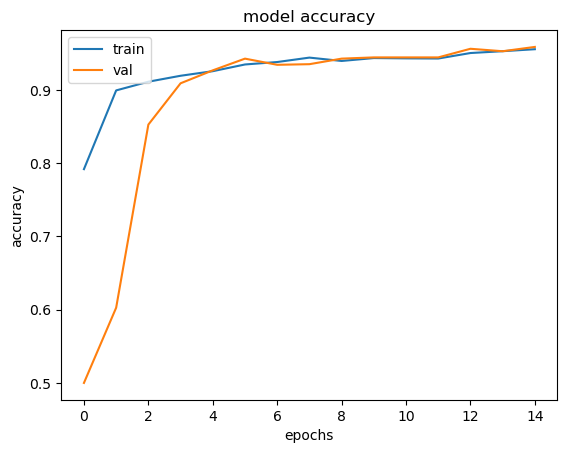

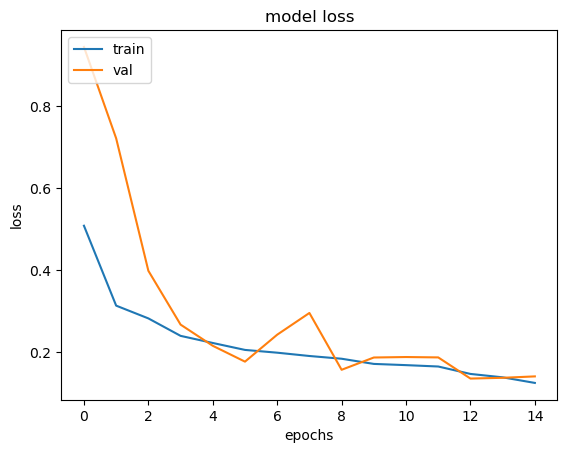

In [ ]:
# plot the accuracy of the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plot the loss of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','val'], loc='upper left')
plt.show()

# save the model
model.save("face_mask_detection.h5")